In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

1. Скачиваю датасет и смотрю содержимое

In [ ]:
from torchvision import datasets, transforms
from torch import nn

transform = transforms.Compose([
    transforms.ToTensor(),                   # Преобразую изображение в тензор с масштабом [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # А затем из тензора делаю 1д вектор с 28*28 = 784 значениями пикселей
])

train_mnist = datasets.MNIST(root='mnist', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='mnist', train=False, download=True, transform=transform)

train_mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [ ]:
from torch.utils.data import random_split

train_size = int(0.9 * len(train_mnist))
val_size = int(0.1 * len(train_mnist))

train_subset, val_subset = random_split(train_mnist, [train_size, val_size])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_mnist, batch_size=BATCH_SIZE)

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
  print(f'Batch: {i}')
  print(f'x.shape: {x.shape}')
  print(f'y.shape: {y.shape}')

# x.shape: torch.Size([50, 784])
# y.shape: torch.Size([50])

Batch: 0
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 1
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 2
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 3
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 4
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 5
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 6
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 7
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 8
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 9
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 10
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 11
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 12
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 13
x.shape: torch.Size([128, 784])
y.shape: torch.Size([128])
Batch: 14
x.shape: torch.Size([128, 784])
y.

2. Создаю модель

In [ ]:
from torch import nn

model = nn.Sequential(
    # input -> 1st hidden
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 1st hidden -> 2nd hidden
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 2nd hidden -> output
    nn.Linear(64, 10)
)

3. Summary

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=64, out_features=10, bias=True)
)

5. Обучаю модель

In [ ]:
# функция для обучения/изучения модели
def run(model, dataloader, loss_fn, optimizer=None):
  if optimizer is None:
    model.eval()
  else:
    model.train()

  total_loss = 0

  for X,y in dataloader:
    pred = model(X)
    loss = loss_fn(pred, y)
    total_loss += loss.item()

    if optimizer is not None:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  return total_loss / len(dataloader)

In [ ]:
from IPython.display import clear_output

# Функция для коллбека построения графиков обучения
def show_losses(train_loss_hist, test_loss_hist):
  clear_output()

  plt.figure(figsize=(12,4))

  plt.subplot(1, 2, 1)
  plt.title('Train Loss')
  plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
  plt.yscale('log')
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.title('Test Loss')
  plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
  plt.yscale('log')
  plt.grid()

  plt.show()

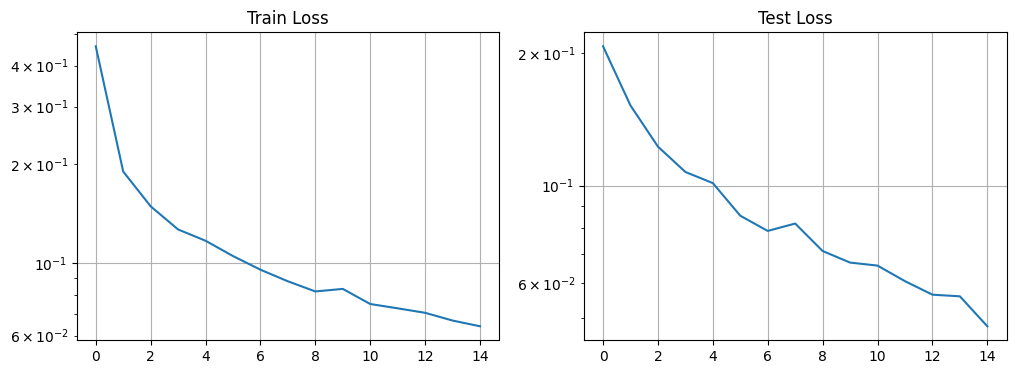

In [ ]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()

# Обучение и коллбек
def train_and_test(model, epochs=5):
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  train_loss_hist, test_loss_hist = [], []
  for i in range(epochs):
    train_loss = run(model, train_dataloader, loss_fn, optimizer)
    test_loss = run(model, test_dataloader, loss_fn, optimizer)

    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

  show_losses(train_loss_hist, test_loss_hist)

train_and_test(model, 15)

5. Оценка результатов

In [ ]:
from sklearn.metrics import classification_report

def valuate(model):
  all_preds, all_labels = [], []

  with torch.no_grad():
    for X, y in test_dataloader:
      logits = model(X)
      pred = logits.argmax(dim=1)
      all_preds.append(pred)
      all_labels.append(y)

  all_preds = torch.cat(all_preds).numpy()
  all_labels = torch.cat(all_labels).numpy()
  print(classification_report(all_preds, all_labels))

In [ ]:
valuate(model)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       993
           1       1.00      0.99      1.00      1139
           2       0.99      0.99      0.99      1027
           3       0.99      0.98      0.98      1017
           4       0.98      1.00      0.99       971
           5       0.98      0.99      0.99       889
           6       0.99      0.99      0.99       956
           7       0.98      0.99      0.98      1021
           8       0.99      0.99      0.99       979
           9       0.98      0.98      0.98      1008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Рубрика эксперименты (с моделями)

In [ ]:
# Гипотеза 1: 1 скрытый слой лучше, чем 2
model_1hl = nn.Sequential(
    # input -> 1st hidden
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 2nd hidden -> output
    nn.Linear(128, 10)
)

# Гипотеза 2: 3 скрытых слоя лучше, чем 2
model_3hl = nn.Sequential(
    # input -> 1st hidden
    nn.Linear(28*28, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 1st hidden -> 2nd hidden
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 2nd hidden -> 3rd hidden
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.25),
    # 2nd hidden -> output
    nn.Linear(64, 10)
)

# Гипотеза 3: Больший dropout лучше
model_higher_drop = nn.Sequential(
    # input -> 1st hidden
    nn.Linear(28*28, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.45),
    # 1st hidden -> 2nd hidden
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.45),
    # 2nd hidden -> output
    nn.Linear(64, 10)
)

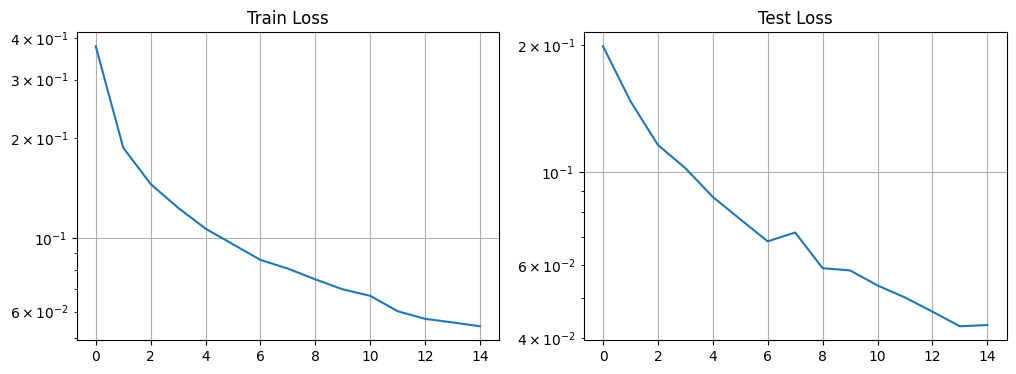

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       985
           1       1.00      0.99      0.99      1141
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1017
           4       0.99      1.00      0.99       975
           5       0.99      0.99      0.99       889
           6       0.99      1.00      0.99       950
           7       0.99      0.99      0.99      1022
           8       0.99      0.98      0.99       981
           9       0.99      0.99      0.99      1008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_test(model_1hl, epochs=15)
valuate(model_1hl)

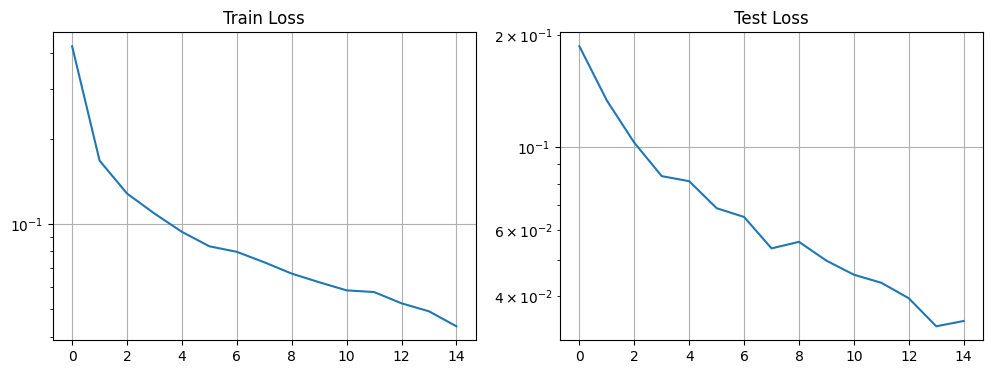

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       988
           1       0.99      0.99      0.99      1136
           2       0.99      0.98      0.99      1042
           3       0.99      0.99      0.99      1004
           4       0.99      0.99      0.99       973
           5       0.99      0.99      0.99       888
           6       0.99      1.00      0.99       954
           7       0.99      0.99      0.99      1025
           8       0.99      0.99      0.99       968
           9       0.99      0.98      0.99      1022

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_test(model_3hl, epochs=15)
valuate(model_3hl)

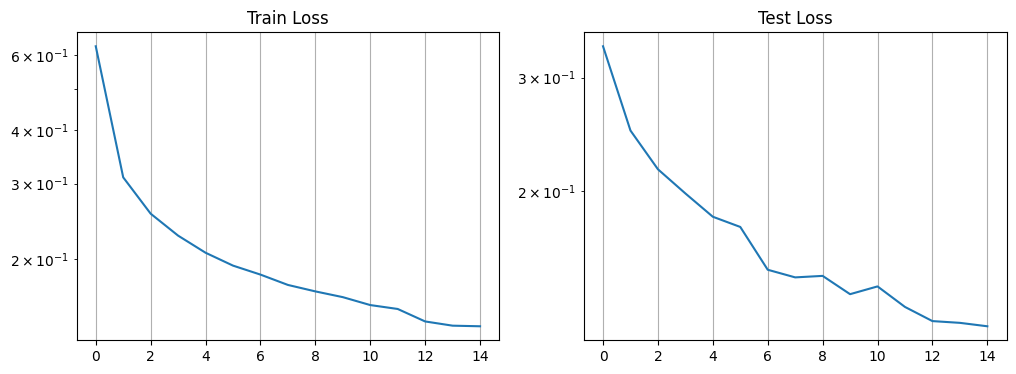

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       992
           1       0.99      0.98      0.99      1139
           2       0.97      0.97      0.97      1031
           3       0.96      0.97      0.97       996
           4       0.96      0.98      0.97       970
           5       0.96      0.95      0.95       901
           6       0.97      0.99      0.98       936
           7       0.97      0.97      0.97      1024
           8       0.97      0.95      0.96       995
           9       0.96      0.95      0.96      1016

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
train_and_test(model_higher_drop, epochs=15)
valuate(model_higher_drop)

#Вывод

Модели с 1, 2 и 3 спрятанными слоями показали примерно одинаковые результаты на метрицах. Так получается из-за того, что датасет большой и достаточно простой для обобщения. Увеличение дропаута, напротив, не помогло в поиске идеальных параметров.

Я считаю, что лучшей архитектурой является первая модель с 2 спрятанными слоями, так как она более универсальная, чем 1-слойная, но менее ресурсозатратная, чем 3-хслойная.